# Twitter Sentiment Analysis Using Deep Learning


## Project Overview
This project implements deep learning models to analyze and classify tweet sentiments into positive, negative, and neutral categories. The implementation explores both Bidirectional LSTM and CNN-LSTM hybrid architectures for optimal sentiment classification.

**Dataset Information:**
- **Source**: Twitter Sentiment Dataset
- **Fields**:
  - text: Tweet content
  - sentiment: Polarity (negative, neutral, positive)

## Setup and Dependencies


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
import tensorflow as tf


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Read the datasets
train_df = pd.read_csv('/content/drive/MyDrive/KIT315_Assignments/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/KIT315_Assignments/test.csv')

## 1. Data Loading and Initial Analysis
The initial phase focuses on understanding our dataset through exploratory data analysis (EDA). We'll examine:
- Class distribution in training data
- Text length patterns
- Vocabulary characteristics
- Word frequency analysis

In [ ]:
print("Dataset Characteristics:")
print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")
print("\nClass distribution in training set:")
print(train_df['sentiment'].value_counts())

Dataset Characteristics:
Training samples: 27481
Testing samples: 3534

Class distribution in training set:
sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64


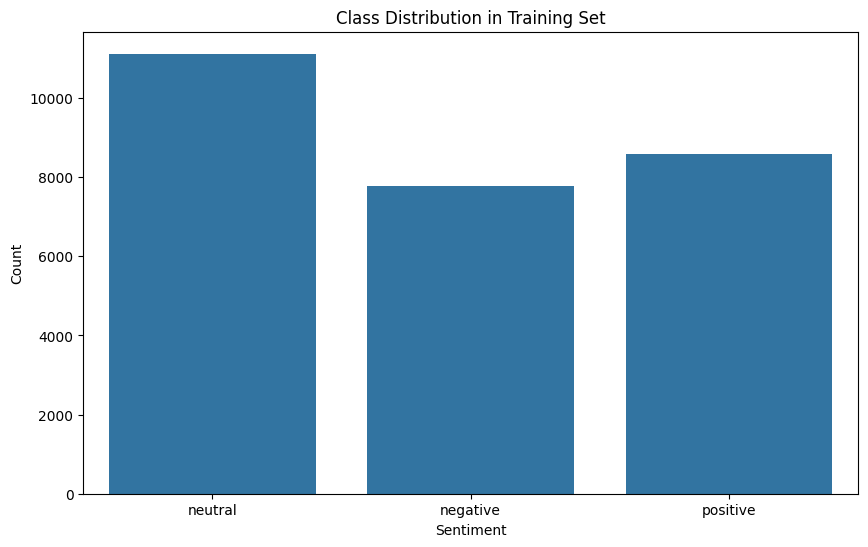

In [ ]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=train_df)
plt.title('Class Distribution in Training Set')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

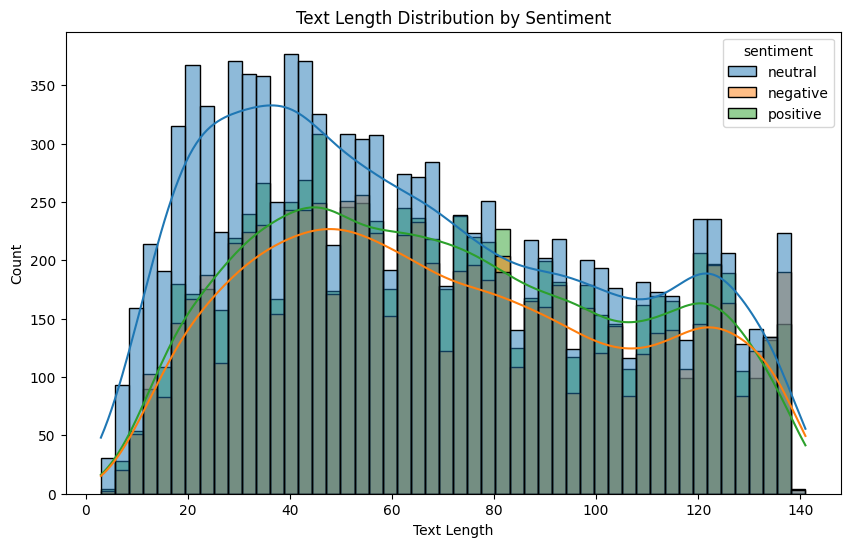

In [ ]:
# Analyze text length distribution
train_df['text_length'] = train_df['text'].astype(str).apply(len) # Convert the 'text' column to string type before applying len
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='text_length', hue='sentiment', bins=50, kde=True)
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

In [ ]:
# Examine vocabulary size
all_words = ' '.join(train_df['text'].astype(str)).split()
vocab_size = len(set(all_words))
print(f"\nVocabulary size: {vocab_size}")


Vocabulary size: 52270


In [ ]:
# Identify common words for each sentiment
def get_top_words(df, sentiment, n=10):
    # Filter for the desired sentiment and ensure 'text' column is of string type
    text_series = df[df['sentiment'] == sentiment]['text'].astype(str)
    # Join the text data, handling potential NaN values
    text = ' '.join(text_series.dropna())
    words = text.split()
    word_freq = pd.Series(words).value_counts()
    return word_freq.head(n)

In [ ]:
for sentiment in train_df['sentiment'].unique():
    print(f"\nTop 10 words for {sentiment} sentiment:")
    print(get_top_words(train_df, sentiment))


Top 10 words for neutral sentiment:
to     4057
I      3365
the    3329
a      2438
my     1800
and    1713
i      1507
in     1501
you    1433
for    1412
Name: count, dtype: int64

Top 10 words for negative sentiment:
I      2956
to     2838
the    2301
my     1778
a      1758
i      1550
and    1442
is     1245
in     1045
it      889
Name: count, dtype: int64

Top 10 words for positive sentiment:
to     2914
the    2758
I      2481
a      2305
you    1583
and    1522
my     1354
for    1308
i      1206
is     1065
Name: count, dtype: int64


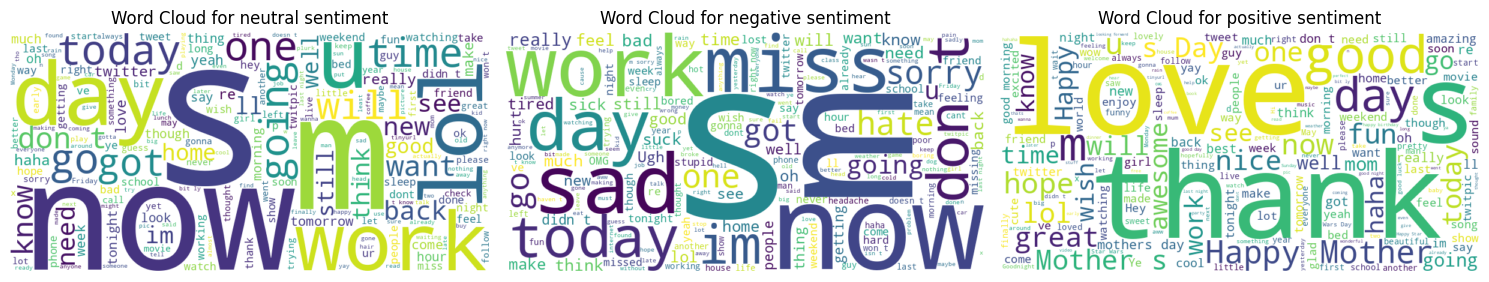

In [ ]:
# Create word clouds for each sentiment
plt.figure(figsize=(15, 5))
for i, sentiment in enumerate(train_df['sentiment'].unique()):
    text = ' '.join(train_df[train_df['sentiment'] == sentiment]['text'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)
    plt.subplot(1, 3, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment} sentiment')
    plt.axis('off')
plt.tight_layout()
plt.show()

## 2. Data Processing
This section prepares our text data for model training through:
- Text cleaning and normalization
- Stop word removal
- Tokenization and sequence padding
- Label encoding
- Train-validation split

In [ ]:
def clean_text(text):
    # Handle float values (e.g., NaN) by converting them to empty strings
    if isinstance(text, float):
        text = str(text)
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [ ]:
# Visualize the effect of text cleaning
sample_text = train_df['text'].iloc[0]
cleaned_sample = clean_text(sample_text)

print("Original text:")
print(sample_text)
print("\nCleaned text:")
print(cleaned_sample)

Original text:
 I`d have responded, if I were going

Cleaned text:
id responded going


In [ ]:
# Clean the text data
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

In [ ]:
# Convert sentiments to numerical values
le = LabelEncoder()
train_df['sentiment_encoded'] = le.fit_transform(train_df['sentiment'])
test_df['sentiment_encoded'] = le.transform(test_df['sentiment'])


In [ ]:
# Tokenize the text
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['cleaned_text'])


In [ ]:
X_train_full = tokenizer.texts_to_sequences(train_df['cleaned_text'])
X_test = tokenizer.texts_to_sequences(test_df['cleaned_text'])

X_train_full = pad_sequences(X_train_full, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

y_train_full = train_df['sentiment_encoded']
y_test = test_df['sentiment_encoded']

In [ ]:
# Split the training data into train and evaluation sets
X_train, X_eval, y_train, y_eval = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

## 3. Model Development
Implementation and comparison of two deep learning architectures:
- Bidirectional LSTM: For capturing contextual information
- CNN-LSTM Hybrid: Combining convolutional and sequential processing

Both models undergo hyperparameter tuning for optimal performance.

In [ ]:
# Model 1: Bidirectional LSTM
def create_bidirectional_lstm_model(lstm_units=64, dense_units=32, dropout_rate=0.3):
    model = Sequential([
        Embedding(max_words, 100, input_length=max_len),
        Bidirectional(LSTM(lstm_units)),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(3, activation='softmax')
    ])
    return model

In [ ]:
# Model 2: CNN-LSTM
def create_cnn_lstm_model(filters=64, kernel_size=5, pool_size=4, lstm_units=64, dense_units=32, dropout_rate=0.3):
    model = Sequential([
        Embedding(max_words, 100, input_length=max_len),
        Conv1D(filters, kernel_size, activation='relu'),
        MaxPooling1D(pool_size=pool_size),
        LSTM(lstm_units),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(3, activation='softmax')
    ])
    return model

In [ ]:
def tune_bidirectional_lstm():
    best_eval_accuracy = 0
    best_model = None
    best_history = None

    learning_rates = [1e-3, 1e-4]
    lstm_units = [32, 64]
    dropout_rates = [0.2, 0.5]

    for lr in learning_rates:
        for lu in lstm_units:
            for dr in dropout_rates:
                print(f"\nTraining Bi-LSTM with lr={lr}, lstm_units={lu}, dropout={dr}")

                model = create_bidirectional_lstm_model(lstm_units=lu, dropout_rate=dr)
                model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy'])

                history = model.fit(X_train, y_train,
                                    epochs=10,
                                    batch_size=32,
                                    validation_data=(X_eval, y_eval),
                                    verbose=1)

                eval_loss, eval_accuracy = model.evaluate(X_eval, y_eval)
                if eval_accuracy > best_eval_accuracy:
                    best_eval_accuracy = eval_accuracy
                    best_model = model
                    best_history = history

    return best_model, best_history

In [ ]:
def tune_cnn_lstm():
    best_eval_accuracy = 0
    best_model = None
    best_history = None

    learning_rates = [1e-3, 1e-4]
    lstm_units = [32, 64]
    dropout_rates = [0.3, 0.5]

    for lr in learning_rates:
        for lu in lstm_units:
            for dr in dropout_rates:
                print(f"\nTraining CNN-LSTM with lr={lr}, lstm_units={lu}, dropout={dr}")

                model = create_cnn_lstm_model(lstm_units=lu, dropout_rate=dr)
                model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy'])

                history = model.fit(X_train, y_train,
                                    epochs=10,
                                    batch_size=32,
                                    validation_data=(X_eval, y_eval),
                                    verbose=1)

                eval_loss, eval_accuracy = model.evaluate(X_eval, y_eval)
                if eval_accuracy > best_eval_accuracy:
                    best_eval_accuracy = eval_accuracy
                    best_model = model
                    best_history = history

    return best_model, best_history

In [ ]:
# Train and tune both models
print("Training and tuning Bidirectional LSTM model:")
best_bilstm_model, bilstm_history = tune_bidirectional_lstm()

Training and tuning Bidirectional LSTM model:

Training Bi-LSTM with lr=0.001, lstm_units=32, dropout=0.2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.5439 - loss: 0.9268 - val_accuracy: 0.7080 - val_loss: 0.6970
Epoch 2/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7736 - loss: 0.5778 - val_accuracy: 0.7027 - val_loss: 0.7057
Epoch 3/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8282 - loss: 0.4641 - val_accuracy: 0.6889 - val_loss: 0.7853
Epoch 4/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8681 - loss: 0.3673 - val_accuracy: 0.6809 - val_loss: 0.9079
Epoch 5/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8933 - loss: 0.3009 - val_accuracy: 0.6764 - val_loss: 1.0056
Epoch 6/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9151 - loss: 0.2316 - val_accuracy: 0.6733 - val_loss: 1.2455
Epoch 7/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9284 - loss: 0.1961 - val_accuracy: 0.6691 - val_loss: 1.4000
Epoch 8/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9420 - loss: 0.1609 - val

In [ ]:
print("\nTraining and tuning CNN-LSTM model:")
best_cnn_lstm_model, cnn_lstm_history = tune_cnn_lstm()


Training and tuning CNN-LSTM model:

Training CNN-LSTM with lr=0.001, lstm_units=32, dropout=0.3
Epoch 1/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.5214 - loss: 0.9548 - val_accuracy: 0.7135 - val_loss: 0.6995
Epoch 2/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7719 - loss: 0.5995 - val_accuracy: 0.6987 - val_loss: 0.7160
Epoch 3/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8525 - loss: 0.4232 - val_accuracy: 0.6966 - val_loss: 0.7826
Epoch 4/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9085 - loss: 0.2774 - val_accuracy: 0.6849 - val_loss: 0.9940
Epoch 5/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9457 - loss: 0.1703 - val_accuracy: 0.6767 - val_loss: 1.2064
Epoch 6/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9624 - loss: 0.1173 - val_accuracy: 0.6691 - val_loss: 1.4395
Epoch 7/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9710 - loss: 0.0935 - val_accuracy: 0.6653 - val_loss: 1.7039
Ep

In [ ]:
# Visualize training history
def plot_training_history(histories):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    for name, history in histories.items():
        plt.plot(history.history['accuracy'], label=f'{name} Training')
        plt.plot(history.history['val_accuracy'], label=f'{name} Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    for name, history in histories.items():
        plt.plot(history.history['loss'], label=f'{name} Training')
        plt.plot(history.history['val_loss'], label=f'{name} Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# Plot the training history
histories = {
    'Bidirectional LSTM': bilstm_history,
    'CNN-LSTM': cnn_lstm_history
}

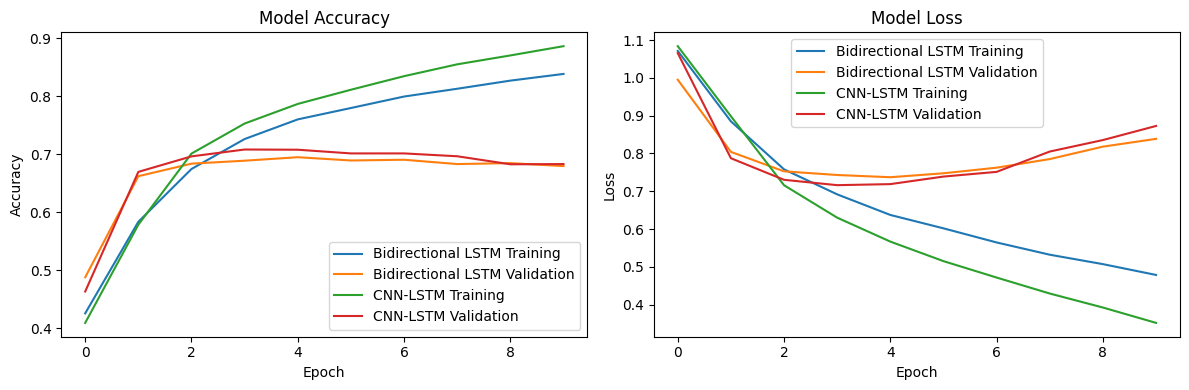

In [ ]:
plot_training_history(histories)

In [ ]:
# Evaluate models on the evaluation set and store metrics
eval_metrics = {}  # Dictionary to store evaluation metrics

models = {
    'Bidirectional LSTM': best_bilstm_model,
    'CNN-LSTM': best_cnn_lstm_model
}

In [ ]:
for name, model in models.items():
    print(f"\nEvaluating {name} on evaluation set:")
    eval_loss, eval_accuracy = model.evaluate(X_eval, y_eval)

    y_pred = model.predict(X_eval)  # Predictions on evaluation set
    y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted classes

    # Store metrics in the dictionary
    eval_metrics[name] = {
        'Evaluation Loss': eval_loss,
        'Evaluation Accuracy': eval_accuracy,
        'Classification Report': classification_report(y_eval, y_pred_classes, target_names=le.classes_, output_dict=True)
    }


Evaluating Bidirectional LSTM on evaluation set:
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6704 - loss: 0.8455
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Evaluating CNN-LSTM on evaluation set:
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6700 - loss: 0.8934
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
# Print performance metrics for each model
for name, metrics in eval_metrics.items():
    print(f"\nPerformance Metrics for {name} (Evaluation Set):")
    print(f"  Evaluation Loss: {metrics['Evaluation Loss']:.4f}")
    print(f"  Evaluation Accuracy: {metrics['Evaluation Accuracy']:.4f}")
    print(f"  Classification Report:")

    # Iterate through the classification report dictionary
    for class_name, scores in metrics['Classification Report'].items():
        if isinstance(scores, dict):  # Check if it's a class-specific dictionary
            print(f"    {class_name}:")
            for metric, value in scores.items():
                print(f"      {metric}: {value:.4f}")  # Format values to 4 decimal places
        else:  # For overall metrics like 'accuracy'
            print(f"    {class_name}: {scores}")


Performance Metrics for Bidirectional LSTM (Evaluation Set):
  Evaluation Loss: 0.8386
  Evaluation Accuracy: 0.6793
  Classification Report:
    negative:
      precision: 0.6872
      recall: 0.6440
      f1-score: 0.6649
      support: 1562.0000
    neutral:
      precision: 0.6377
      recall: 0.6655
      f1-score: 0.6513
      support: 2230.0000
    positive:
      precision: 0.7292
      recall: 0.7296
      f1-score: 0.7294
      support: 1705.0000
    accuracy: 0.6792796070583955
    macro avg:
      precision: 0.6847
      recall: 0.6797
      f1-score: 0.6819
      support: 5497.0000
    weighted avg:
      precision: 0.6801
      recall: 0.6793
      f1-score: 0.6794
      support: 5497.0000

Performance Metrics for CNN-LSTM (Evaluation Set):
  Evaluation Loss: 0.8727
  Evaluation Accuracy: 0.6827
  Classification Report:
    negative:
      precision: 0.6699
      recall: 0.6677
      f1-score: 0.6688
      support: 1562.0000
    neutral:
      precision: 0.6424
      re

## 4. Model Evaluation and Analysis
Comprehensive evaluation of model performance using:
- Accuracy metrics
- Classification reports
- Confusion matrices
- Training history visualization

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1_l2
from sklearn.model_selection import StratifiedKFold

def create_cnn_model(filters=128, kernel_size=5, dense_units=64, dropout_rate=0.5, l1_reg=0.01, l2_reg=0.01):
    model = Sequential([
        Embedding(max_words, 100, input_length=max_len),
        Conv1D(filters, kernel_size, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)),  # Add regularization
        GlobalMaxPooling1D(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(3, activation='softmax')
    ])
    return model

In [ ]:
def tune_cnn_with_overfitting_prevention():
    best_eval_accuracy = 0
    best_model = None
    best_history = None

    # hyperparameter tuning
    learning_rates = [1e-3, 1e-4]
    filters = [64, 128]
    kernel_sizes = [3, 5]
    dense_units = [32, 64]
    dropout_rates = [0.3, 0.5]
    l1_regs = [0.01, 0.001]
    l2_regs = [0.01, 0.001]

    for lr in learning_rates:
        for f in filters:
            for ks in kernel_sizes:
                for du in dense_units:
                    for dr in dropout_rates:
                        for l1_reg in l1_regs:
                            for l2_reg in l2_regs:
                                print(f"\nTraining CNN with lr={lr}, filters={f}, kernel_size={ks}, dense_units={du}, dropout={dr}, l1_reg={l1_reg}, l2_reg={l2_reg}")

                                model = create_cnn_model(filters=f, kernel_size=ks, dense_units=du, dropout_rate=dr, l1_reg=l1_reg, l2_reg=l2_reg)
                                model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                                              loss='sparse_categorical_crossentropy',
                                              metrics=['accuracy'])

                                # Early stopping to prevent overfitting
                                early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

                                history = model.fit(X_train, y_train,
                                                    epochs=10,
                                                    batch_size=32,
                                                    validation_data=(X_eval, y_eval),
                                                    callbacks=[early_stopping],
                                                    verbose=1)

                                _, eval_accuracy = model.evaluate(X_eval, y_eval, verbose=0)  # Get evaluation accuracy
                                print(f"Evaluation Accuracy: {eval_accuracy:.4f}")

                                if eval_accuracy > best_eval_accuracy:
                                    best_eval_accuracy = eval_accuracy
                                    best_model = model
                                    best_history = history

    return best_model, best_history

In [ ]:
# Train and tune the Bi-LSTM model with overfitting prevention
best_cnn_model, cnn_history = tune_cnn_with_overfitting_prevention()


Training CNN with lr=0.001, filters=64, kernel_size=3, dense_units=32, dropout=0.3, l1_reg=0.01, l2_reg=0.01
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4017 - loss: 3.3614 - val_accuracy: 0.4057 - val_loss: 1.1097
Epoch 2/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4052 - loss: 1.1093 - val_accuracy: 0.4057 - val_loss: 1.1092
Epoch 3/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4100 - loss: 1.1083 - val_accuracy: 0.4057 - val_loss: 1.1094
Epoch 4/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4039 - loss: 1.1092 - val_accuracy: 0.4057 - val_loss: 1.1090
Epoch 5/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4047 - loss: 1.1095 - val_accuracy: 0.4057 - val_loss: 1.1094
Epoch 6/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4068 - loss: 1.1090 - val_accuracy: 0.4057 - val_loss: 1.1090
Epoch 7/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4025 - loss: 1.1096 - val_accuracy: 0.4057 - val_loss: 1.1090
Evaluation Accuracy: 0.4057

Training CNN with lr=0.001, filters=64, kernel_size=3, dense_units=32, dropout=0.3, l1

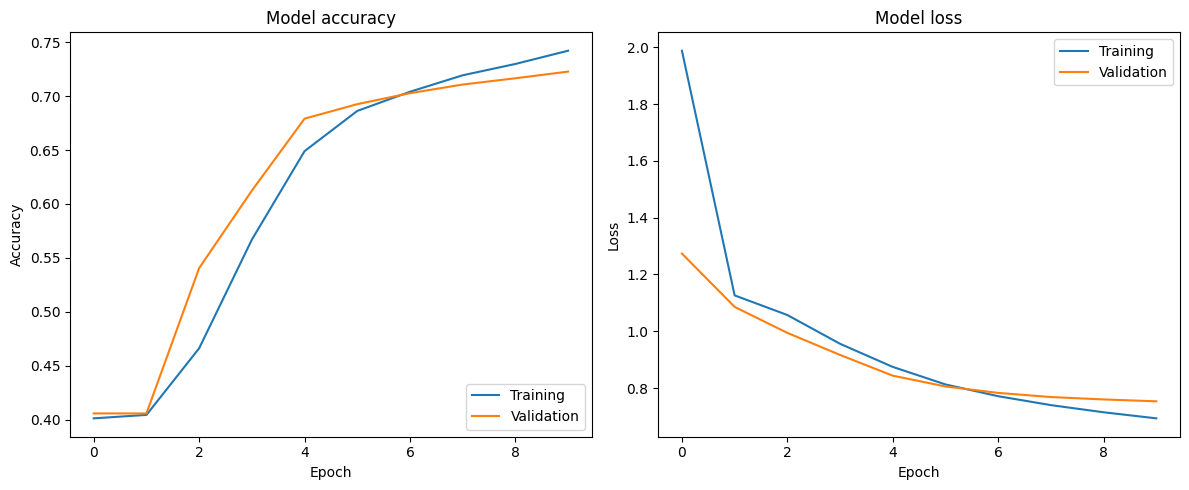

In [ ]:
# Visualize training history
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Training')
plt.plot(cnn_history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Training')
plt.plot(cnn_history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the best Bi-LSTM model on the test set
print("\nEvaluating the best CNN LSTM model on the test set:")
test_loss, test_accuracy = best_cnn_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")



Evaluating the best CNN LSTM model on the test set:
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7165 - loss: 0.7479
Test Loss: 0.7468
Test Accuracy: 0.7134


In [ ]:
y_pred = best_cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))


111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.65      0.69      1001
     neutral       0.66      0.72      0.69      1430
    positive       0.78      0.75      0.77      1103

    accuracy                           0.71      3534
   macro avg       0.72      0.71      0.72      3534
weighted avg       0.72      0.71      0.71      3534



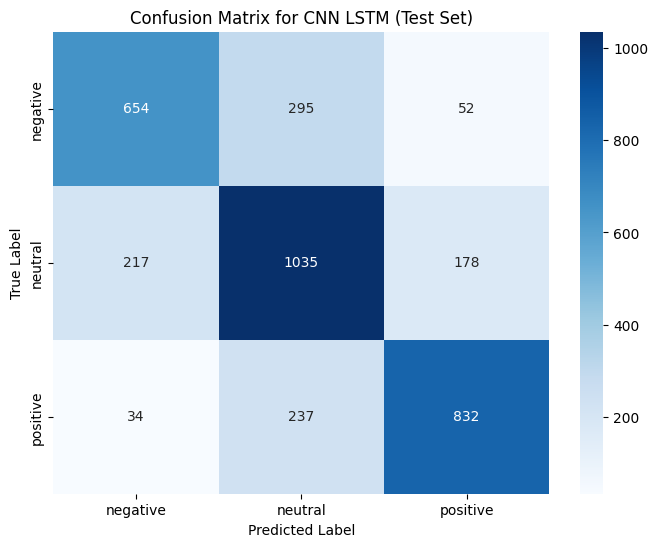

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('Confusion Matrix for CNN LSTM (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()